In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error
from itertools import product
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tools.eval_measures import rmse
from pmdarima import auto_arima

In [32]:
# Load the data
from uwv.config import CBS80072NED, CBS_OPENDATA_PROCESSED_DATA_DIR, OUTPUT_DIR

cbs = pd.read_parquet(CBS_OPENDATA_PROCESSED_DATA_DIR / f"{CBS80072NED}.parquet")

In [33]:
# Data Preprocessing
# Filter out rows where 'period_quarter_number' is 0
cbs = cbs[cbs['period_quarter_number'] != 0]

In [34]:
# Map quarters to months and create the 'date' column
cbs['month'] = cbs['period_quarter_number'].map({1: 1, 2: 4, 3: 7, 4: 10})
cbs['date'] = pd.to_datetime({'year': cbs['period_year'], 'month': cbs['month'], 'day': 1})

In [35]:
# Set this new 'date' column as the index
cbs.set_index('date', inplace=True)

In [36]:
# Filter data based on 'sbi_title'
sbi_code = 'T001081'  # Example: A-U Alle economische activiteiten
filtered_cbs = cbs[cbs['sbi'] == sbi_code]

In [37]:
# Filter the data to include only dates from 2008 to 2023
filtered_cbs = filtered_cbs.loc['2008-01-01':'2023-12-31']

In [38]:
# Set the frequency to quarterly
filtered_cbs.index.freq = 'QS'

In [39]:
# Drop any NaN values to clean the dataset
filtered_cbs = filtered_cbs.dropna()

In [40]:
# Ensure the 'sick_leave_percentage' column is in the correct format
filtered_cbs['sick_leave_percentage'] = filtered_cbs['sick_leave_percentage'].astype(float)

In [41]:
# Set global style parameters
rcParams['axes.facecolor'] = 'white'  # Set background to white
rcParams['grid.color'] = 'grey'  # Set grid lines to grey
rcParams['grid.linestyle'] = '--'  # Optional: dashed grid lines
rcParams['axes.edgecolor'] = 'black'  # Make the axes borders black
rcParams['axes.spines.top'] = False  # Remove the top spine
rcParams['axes.spines.bottom'] = False  # Remove the bottom spine
rcParams['axes.spines.right'] = False  # Remove the right spine
rcParams['axes.spines.left'] = False  # Remove the left spine
rcParams['axes.linewidth'] = 0.5  # Make axis lines thinner
rcParams['font.family'] = 'Roboto'  # Set font to Roboto

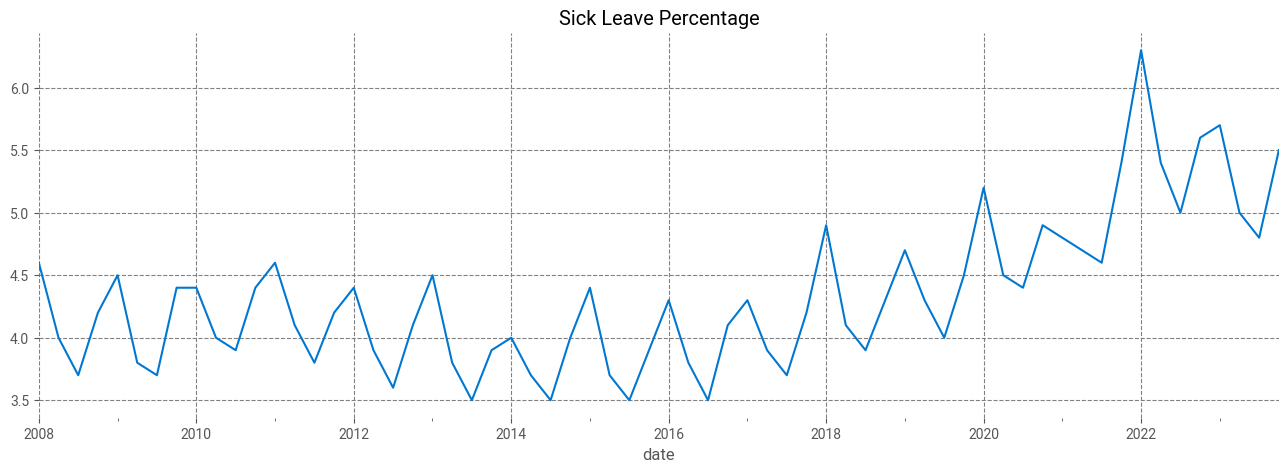

In [42]:
# Example Plot: Sick Leave Percentage
filtered_cbs['sick_leave_percentage'].plot(
    figsize=(16, 5), 
    title='Sick Leave Percentage', 
    linewidth=1.5,  # Line thickness
    color='#0078d2'  # Set the line color to #0078d2
)
plt.grid(True)  # Enable grid
plt.show()

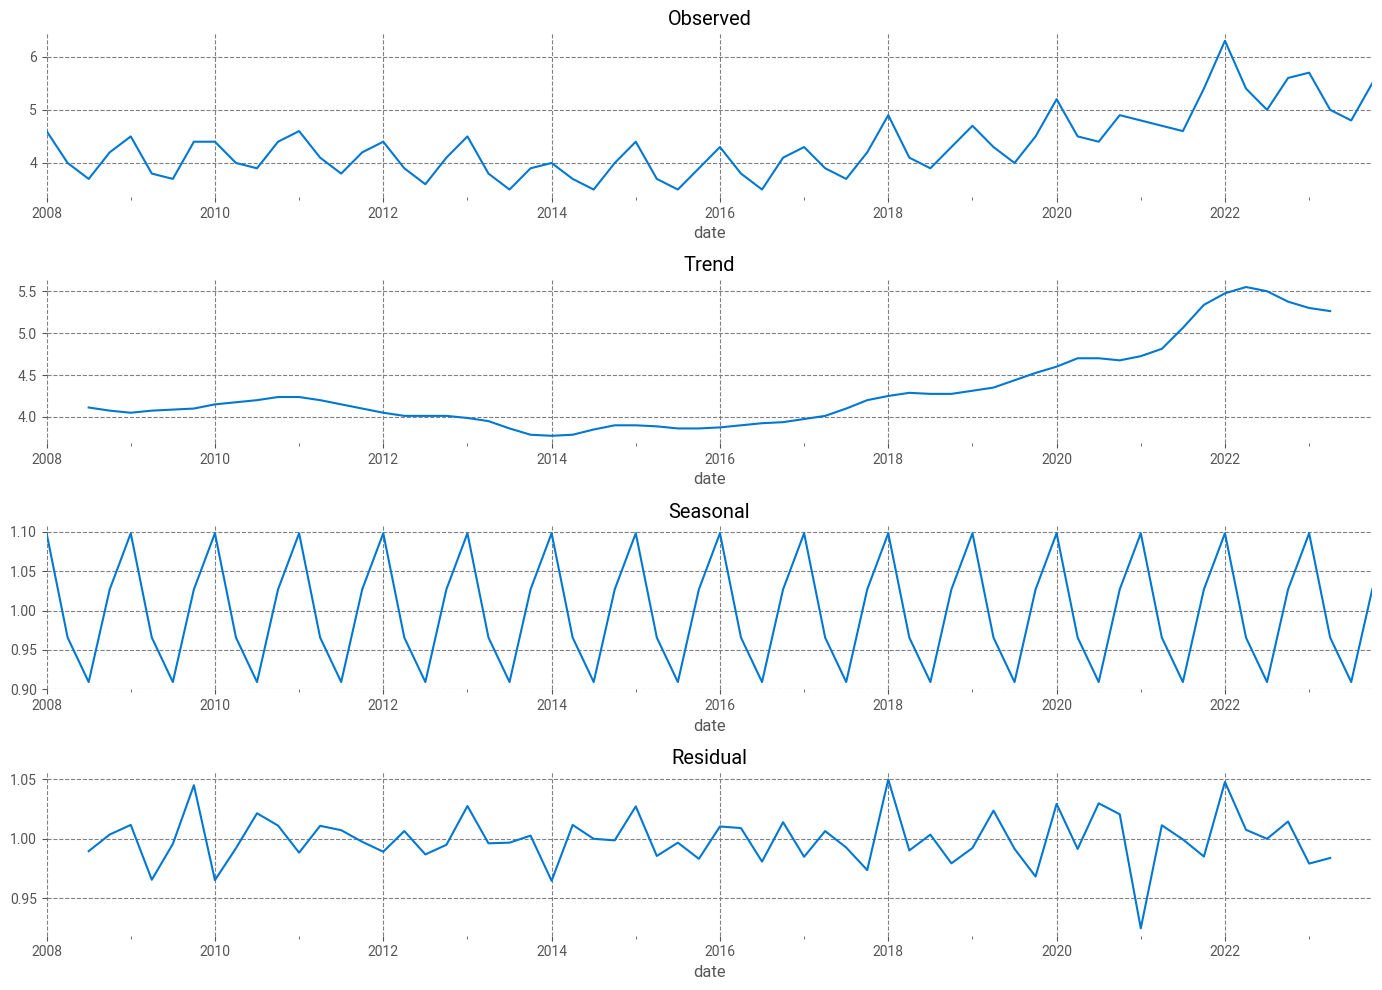

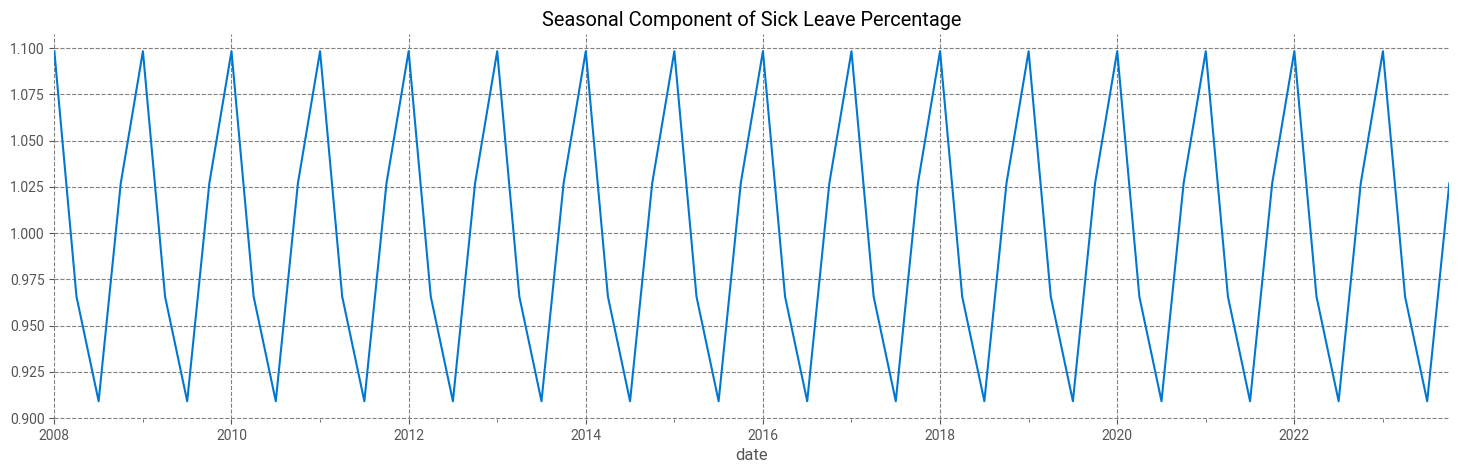

In [43]:
# Perform seasonal decomposition
result = seasonal_decompose(filtered_cbs['sick_leave_percentage'], model='multiplicative')

# Custom plotting of decomposition components with the desired style
fig, axes = plt.subplots(4, 1, figsize=(14, 10))

# Observed
result.observed.plot(ax=axes[0], color='#0078d2', linewidth=1.5)
axes[0].set_title('Observed')
axes[0].grid(True)

# Trend
result.trend.plot(ax=axes[1], color='#0078d2', linewidth=1.5)
axes[1].set_title('Trend')
axes[1].grid(True)

# Seasonal
result.seasonal.plot(ax=axes[2], color='#0078d2', linewidth=1.5)
axes[2].set_title('Seasonal')
axes[2].grid(True)

# Residual
result.resid.plot(ax=axes[3], color='#0078d2', linewidth=1.5)
axes[3].set_title('Residual')
axes[3].grid(True)

plt.tight_layout()
plt.show()

# Seasonal Component Plot
result.seasonal.plot(
    figsize=(18, 5), 
    title='Seasonal Component of Sick Leave Percentage', 
    linewidth=1.5,
    color='#0078d2'
)
plt.show()

In [44]:
# Define Training and Test Sets
train = filtered_cbs.iloc[:-8]  # Use all but the last 8 quarters for training
test = filtered_cbs.iloc[-8:]   # Use the last 8 quarters for testing

In [45]:

# Auto ARIMA Suggestion
auto_arima(train['sick_leave_percentage'], seasonal=True, m=4).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   56
Model:             SARIMAX(0, 1, 1)x(1, 1, [], 4)   Log Likelihood                  17.685
Date:                            Fri, 04 Oct 2024   AIC                            -29.370
Time:                                    14:45:28   BIC                            -23.574
Sample:                                01-01-2008   HQIC                           -27.155
                                     - 10-01-2021                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4750      0.155     -3.057      0.002      -0.780      -0.170
ar.S.L4       -0.7218      0.145     -4.966      0.000      -1.007      -0.437
sigma2         0.0274      0.005      5.297      0.000       0.017       0.038
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 5.97
Prob(Q):                              0.97   Prob(JB):                         0.05
Heteroskedasticity (H):               2.10   Skew:                            -0.49
Prob(H) (two-sided):                  0.14   Kurtosis:                         4.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [46]:
# Define the Function to Find the Best SARIMAX Model
def find_best_sarimax(train, p_values, d_values, q_values, P_values, D_values, Q_values, m):
    best_aic = float("inf")
    best_order = None
    best_seasonal_order = None
    best_model = None

In [47]:
# Define the Function to Find the Best SARIMAX Model
def find_best_sarimax(train, p_values, d_values, q_values, P_values, D_values, Q_values, m):
    best_aic = float("inf")
    best_order = None
    best_seasonal_order = None
    best_model = None

    # Iterate over all combinations of (p, d, q) and (P, D, Q)
    for p, d, q in product(p_values, d_values, q_values):
        for P, D, Q in product(P_values, D_values, Q_values):
            try:
                # Define the SARIMAX model
                model = SARIMAX(
                    train,
                    order=(p, d, q),
                    seasonal_order=(P, D, Q, m),
                    enforce_stationarity=False,
                    enforce_invertibility=False
                )
                
                # Fit the model
                results = model.fit(disp=False)
                
                # Check if the current model has the best AIC
                if results.aic < best_aic:
                    best_aic = results.aic
                    best_order = (p, d, q)
                    best_seasonal_order = (P, D, Q, m)
                    best_model = results
            except Exception as e:
                # Handle any errors during fitting
                print(f"Error with order {(p, d, q)} and seasonal order {(P, D, Q, m)}: {e}")
                continue

    print(f"Best SARIMAX order: {best_order}, seasonal order: {best_seasonal_order}, AIC: {best_aic}")
    return best_model

# Define ranges for the parameters
p = range(0, 3)     # p-values range from 0 to 2
d = range(0, 2)     # d-values range from 0 to 1
q = range(0, 3)     # q-values range from 0 to 2
P = range(0, 3)     # Seasonal P-values range from 0 to 2
D = range(0, 2)     # Seasonal D-values range from 0 to 1
Q = range(0, 3)     # Seasonal Q-values range from 0 to 2
m = 4               # Seasonal period is 4 (quarterly data)

In [48]:
# Find the Best Model
best_model = find_best_sarimax(train['sick_leave_percentage'], p, d, q, P, D, Q, m)

c:\Users\c.hakker\OneDrive - VISTA college\Senior Stuff\Opleiding Data science\uwv\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\c.hakker\OneDrive - VISTA college\Senior Stuff\Opleiding Data science\uwv\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\c.hakker\OneDrive - VISTA college\Senior Stuff\Opleiding Data science\uwv\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\c.hakker\OneDrive - VISTA college\Senior Stuff\Opleiding Data science\uwv\.venv\Lib\site-packages\statsmodels\base\model.py:

Best SARIMAX order: (0, 1, 1), seasonal order: (1, 1, 0, 4), AIC: -27.49681949336803


c:\Users\c.hakker\OneDrive - VISTA college\Senior Stuff\Opleiding Data science\uwv\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [49]:
# Evaluate the best model on the test set
start = len(train)
end = len(train) + len(test) - 1
predictions = best_model.predict(start=start, end=end).rename('SARIMAX Predictions')

In [50]:
# Calculate and print RMSE
rmse_value = rmse(test['sick_leave_percentage'], predictions)
print(f'RMSE: {rmse_value}')

RMSE: 0.386205101131955


In [51]:
# Calculate MAE for predictions
from sklearn.metrics import mean_absolute_error

# Calculate MAE for all four quarters (already implemented)
mae_value = mean_absolute_error(test['sick_leave_percentage'], predictions)
print(f'MAE for all four quarters: {mae_value}')

# Calculate MAE for the next quarter (Q1)
mae_q1 = mean_absolute_error(test['sick_leave_percentage'].iloc[:1], predictions.iloc[:1])
print(f'MAE for the next quarter (Q1): {mae_q1}')


MAE for all four quarters: 0.31480131652884136
MAE for the next quarter (Q1): 0.5556718840761983


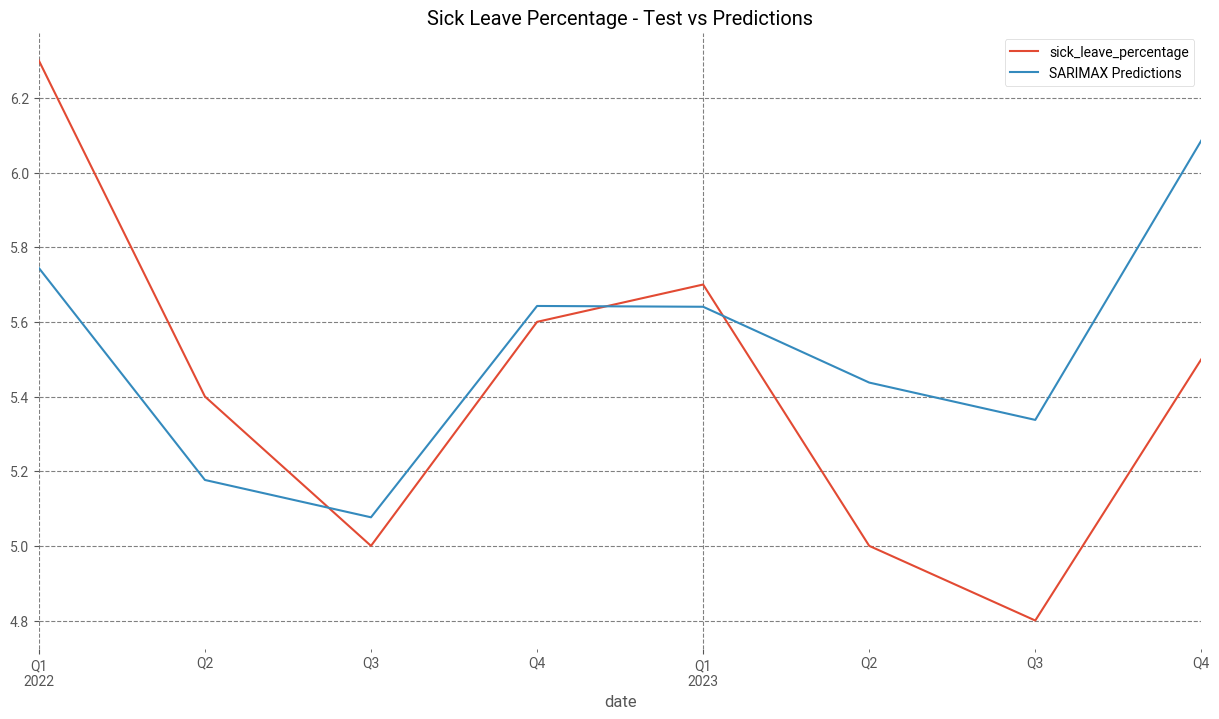

In [52]:
# Test vs Predictions Plot
ax = test['sick_leave_percentage'].plot(
    legend=True, 
    figsize=(15, 8), 
    title='Sick Leave Percentage - Test vs Predictions', 
    linewidth=1.5
)
predictions.plot(legend=True, ax=ax, linewidth=1.5)
plt.show()

In [53]:
# Train SARIMAX on the Full Dataset - Option 1
#final_model = SARIMAX(filtered_cbs['sick_leave_percentage'],
                      #order=(1, 0, 1),  # No differencing
                      #seasonal_order=(1, 0, 1, 4),  # Seasonal order with no differencing
                      #enforce_stationarity=False,
                      #enforce_invertibility=False)

#final_results = final_model.fit(maxiter=1000, method='lbfgs')

# Outcome:Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.This warning suggests that the model does not have enough data points to reliably estimate the initial values of the seasonal AR and MA parameters. As a result, the starting parameters (coefficients) for these components are set to zero to allow the model to proceed.
# Insufficient Data: Seasonal components require enough seasonal cycles (repeated patterns) in the data to estimate the parameters effectively. If your time series is too short or lacks sufficient seasonal cycles, the model cannot accurately determine these parameters.


In [54]:
# Simplified SARIMAX model with reduced seasonal order - Option 2
#final_model = SARIMAX(filtered_cbs['sick_leave_percentage'],
                      #order=(1, 0, 1),  # No differencing
                      #seasonal_order=(0, 0, 0, 4),  # Simplified seasonal order
                      #enforce_stationarity=False,
                      #enforce_invertibility=False)

#final_results = final_model.fit(maxiter=1000, method='lbfgs')

In [55]:
# Adjusted SARIMAX model fitting with increased iterations and different optimization method - Option 3
final_model = SARIMAX(filtered_cbs['sick_leave_percentage'],
                      order=(1, 0, 1),
                      seasonal_order=(1, 0, 1, 4),
                      enforce_stationarity=False,
                      enforce_invertibility=False)

final_results = final_model.fit(maxiter=2000, method='powell', tol=1e-6)

# Check the results
print(final_results.summary())

# Inspect optimization details if convergence warning persists
print(final_results.mle_retvals)


c:\Users\c.hakker\OneDrive - VISTA college\Senior Stuff\Opleiding Data science\uwv\.venv\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method powell is: xtol, ftol, maxfun, start_direc. The list of unsupported keyword arguments passed include: tol. After release 0.14, this will raise.
  warnings.warn(


Optimization terminated successfully.
         Current function value: -0.201330
         Iterations: 5
         Function evaluations: 284
                                     SARIMAX Results                                     
Dep. Variable:             sick_leave_percentage   No. Observations:                   64
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 4)   Log Likelihood                  12.885
Date:                           Fri, 04 Oct 2024   AIC                            -15.770
Time:                                   14:46:20   BIC                             -5.468
Sample:                               01-01-2008   HQIC                           -11.757
                                    - 10-01-2023                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------

In [56]:
# Forecast Future Values
forecast_steps = 8  # Number of quarters to forecast
fcast = final_results.predict(len(filtered_cbs), len(filtered_cbs) + forecast_steps - 1).rename('SARIMAX Forecast')


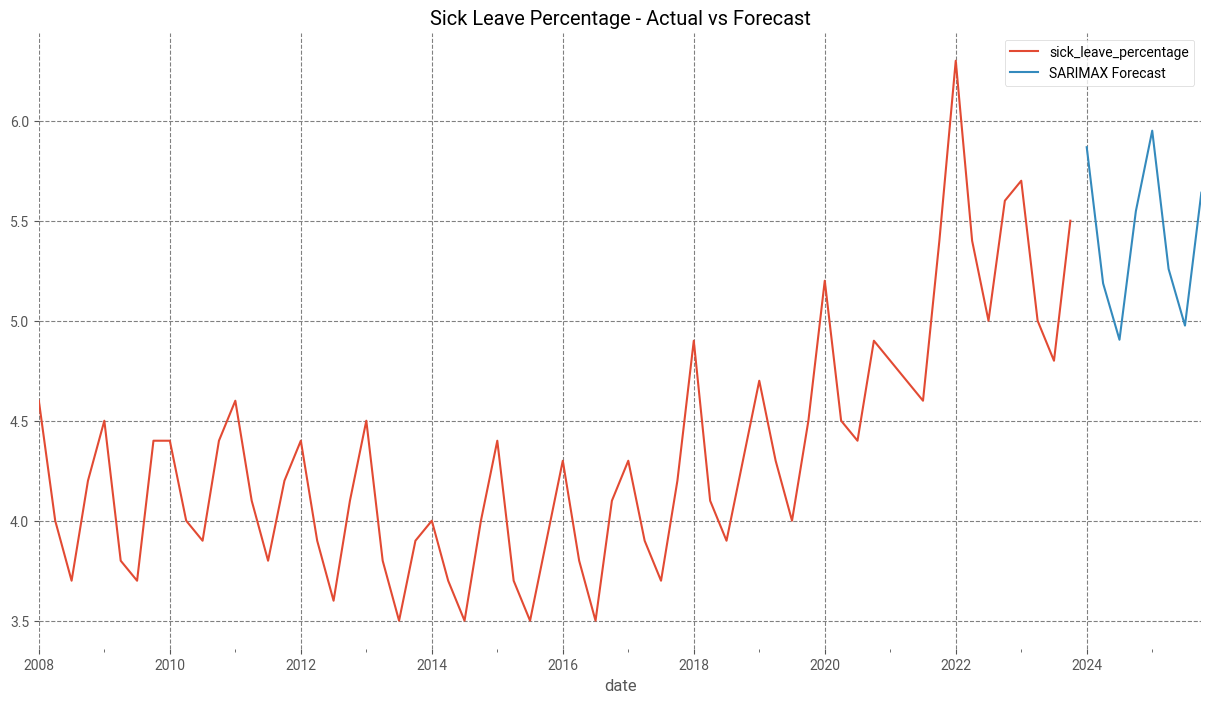

In [57]:
# Plotting the forecast
ax = filtered_cbs['sick_leave_percentage'].plot(legend=True, figsize=(15,8), title='Sick Leave Percentage - Actual vs Forecast')
fcast.plot(legend=True)

plt.show()